# Tutorial 4.3: Two-Compartment Model of Intrinsically Bursting Neuron

## Neuroscience goal:
- understand how two compartments affect each other and how bursting neurons respond to applied current

## Computational goal:
- gain further familiarity with function calls

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 1. save files from PR_soma_gating.m and PR_dend_gating.m
- rewriting the functions in python below instead

In [ ]:
def dend_gating(v_dend, ca):
    """
    Returns rate constants for dendritic gating variables of Pinsky-Rinzel model
    Function of dendritic membrane potential and dendritic calcium concentration

    Parameters
    ----------
    v_dend : np.np.ndarray
        Dendritic membrane potential
    ca : np.np.ndarray
        Dendritic calcium concentration

    Returns
    -------
    alpha_mca : np.array
        Calcium activation rate constant
    beta_mca : np.array
        Calcium deactivation rate constant
    alpha_kca : np.array
        Calcium-dependent potassium activation rate constant
    beta_kca : np.array
        Calcium-dependent potassium deactivation rate constant
    alpha_kahp : np.array
        After-hyperpolarizatoin activation rate constant
    beta_kahp : np.array
        After-hyperpolarization deactivation rate constant
    """
    
    alpha_mca = 1600 /  (1 + np.exp(-72 * (v_dend - 0.005)))

    beta_mca = np.where(v_dend == -0.0089, 20 / 0.2,
                        20e3 * (v_dend + 0.0089) / (np.exp(200 * (v_dend + 0.0089)) - 1))

    alpha_kca = np.where(v_dend > -0.010,
                         2e3 * np.exp(-(0.0535 + v_dend) / 0.027),
                         np.exp((v_dend + 0.050) / 0.011 - (v_dend + 0.0535) / 0.027) / 0.018975)
                         
    

    beta_kca = np.where(v_dend <= -0.010,
                        2e3 * np.exp(-(0.0535 + v_dend) / 0.027) - alpha_kca,
                                     0)
    
    alpha_kahp = np.minimum(20, 20e3 * ca)

    beta_kahp = 4 * np.ones_like(alpha_kahp)

    return alpha_mca, beta_mca, alpha_kca, beta_kca, alpha_kahp, beta_kahp

In [ ]:
def soma_gating(v_soma: np.ndarray):
    """
    Returns rate constants for somatic gating variables of Pinsky-Rinzel model
    Function of somatic membrane potential

    Parameters
    ----------
    v_soma : np.ndarray
        Somatic membrane potential
    
    Returns
    -------
    alpha_m : np.array
        Sodium activation rate constant
    beta_m : np.array
        Sodium deactivation rate constant
    alpha_h : np.array
        Sodium inactivation rate constant
    beta_h : np.array
        Sodium deinactivation rate constant
    alpha_n : np.array
        Potassium activation rate constant
    beta_n : np.array
        Potassium deactivation rate constant
    """

    alpha_m = np.where(v_soma == -0.0469, 320 / 0.25,
                       320e3 * (v_soma + 0.0469) / (1 - np.exp(-250 * (v_soma + 0.0469))))
    
    beta_m = np.where(v_soma == -0.0199, 280 / 0.2,
                      280e3 * (v_soma + 0.0199) / (np.exp(200 * (v_soma + 0.0199)) - 1))

    alpha_h = 128 * np.exp(-(v_soma + 0.043) / 0.018)
    beta_h = 4e3 / (1 + np.exp(-200 * (v_soma + 0.020)))

    alpha_n = np.where(v_soma == -0.0249, 16 / 0.2,
                       16e3 * (v_soma + 0.0249) / (1 - np.exp(-200 * (v_soma + 0.0249))))
    beta_n = 250 * np.exp(-25 * (v_soma + 0.040))

    return alpha_m, beta_m, alpha_h, beta_h, alpha_n, beta_n

## 2. Plot membrane potential and calcium concentration 
- generate a vector of values for membrane potential (between -0.085 and 0.050 V)
- generate a vector of values for calcium concentration (between 0 and 2e-3 M)
- plot all twelve rate constants for gating variables on a suitable number of figures

In [ ]:
vm_values = np.linspace(-85e-3, 50e-3, 20)
ca_values = np.linspace(0, 2e-3, 20)

In [ ]:
alpha_mca, beta_mca, alpha_kca, beta_kca, alpha_kahp, beta_kahp = dend_gating(vm_values, ca_values)
alpha_m, beta_m, alpha_h, beta_h, alpha_n, beta_n = soma_gating(vm_values)

In [ ]:
sns.set(style='whitegrid')
fig, ax = plt.subplots(2, 3, figsize=(12, 8))

soma_data = [(alpha_m, beta_m, '$\\alpha_m$', '$\\beta_m$'),
             (alpha_h, beta_h, '$\\alpha_h$', '$\\beta_h$'),
             (alpha_n, beta_n, '$\\alpha_n$', '$\\beta_n$')]

dend_data = [(alpha_mca, beta_mca, '$\\alpha_{mca}$', '$\\beta_{mca}$'),
             (alpha_kca, beta_kca, '$\\alpha_{kca}$', '$\\beta_{kca}$'),
             (alpha_kahp, beta_kahp, '$\\alpha_{KAHP}$', '$\\beta_{KAHP}$')]

# somatic
for i, (alpha, beta, label_alpha, label_beta) in enumerate(soma_data):
    ax[0, i].plot(vm_values, alpha, label=label_alpha)
    ax[0, i].plot(vm_values, beta, label=label_beta)
    ax[1, i].set_xlabel('$V_m$ (V)')

# dendritic
for i, (alpha, beta, label_alpha, label_beta) in enumerate(dend_data):
    ax[1, i].plot(vm_values, alpha, label=label_alpha)
    ax[1, i].plot(vm_values, beta, label=label_beta)
    if i == 2:
        ax[1, i].set_xlabel('calcium concentration (M)')
    else:
        ax[1, i].set_xlabel('$V_m$ (V)')

# titles
ax[0, 1].set_title('somatic rate constants')
ax[1, 1].set_title('dendritic rate constants')

# legends
for row in ax:
    for col in row:
        col.legend()

plt.tight_layout()

## 3. Simulate the Pinsky-Rinzel model
- for 2s, using timestep of 2us
- employ same functions and parameters as tables 4.7 and 4.8
    - except set k = ($5e6 MC^{-1}/A_D$)
    - except set g_link = 50nS

In [ ]:
def reset_params():
    """reset global parameters"""
    global area_soma, area_dend, g_s_leak, g_d_leak
    global g_max_na, g_max_k, g_max_ca, g_max_kca
    global g_max_kahp, g_link, e_na, e_ca, e_k, e_leak
    global c_soma, c_dend, tau_ca, k

    area_soma = 1/3                   # soma fractional area
    area_dend = 2/3                   # dendrite fractional area
    g_s_leak = area_soma * 1e-9       # somatic leak conductance
    g_d_leak = area_dend * 1e-9       # dendritic leak conductance
    g_max_na = area_soma * 3e-6       # max sodium conductance
    g_max_k = area_soma * 2e-6        # max delayed rectifier conductance
    g_max_ca = area_dend * 2.5e-6     # max calcium conductance
    g_max_kca = area_dend * 5e-6      # max calcium-dependent potassium conductance
    g_max_kahp = area_dend * 60e-9    # max after-hyperpolarization conductance 
    g_link = 50e-9                    # link conductance
    e_na = 60e-3                      # sodium reversal potential
    e_ca = 80e-3                      # calcium reversal potential
    e_k = -75e-3                      # potassium reversal potential
    e_leak = -60e-3                   # leak reversal potential
    c_soma = area_soma * 100e-12      # somatic capacitance
    c_dend = area_dend * 100e-12      # dendritic capacitance
    tau_ca = 50e-3                    # calcium decay time constant
    k = (5e6)/area_dend               # conversion from charge to concentration

reset_params()

In [ ]:
def reset_params():
    """reset global parameters"""
    global g_s_leak, g_d_leak
    global g_max_na, g_max_k, g_max_ca, g_max_kca
    global g_max_kahp, g_link, e_na, e_ca, e_k, e_leak
    global c_soma, c_dend, tau_ca, k

    g_s_leak = 1e-9       # somatic leak conductance
    g_d_leak = 1e-9       # dendritic leak conductance
    g_max_na = 5e-6       # increased max sodium conductance
    g_max_k = 2e-6        # max delayed rectifier conductance
    g_max_ca = 2.5e-6     # max calcium conductance
    g_max_kca = 5e-6      # max calcium-dependent potassium conductance
    g_max_kahp = 60e-9    # max after-hyperpolarization conductance
    
    g_link = 10e-9        # link conductance
    
    e_na = 60e-3          # sodium reversal potential
    e_ca = 80e-3          # calcium reversal potential
    e_k = -75e-3          # potassium reversal potential
    e_leak = -60e-3       # leak reversal potential
    
    c_soma = 100e-12      # somatic capacitance
    c_dend = 100e-12      # dendritic capacitance
    
    tau_ca = 50e-3        # calcium decay time constant
    
    k = 5e6               # conversion from charge to concentration

reset_params()


In [ ]:
def update_soma(i, v_s_sim, v_d_sim, m_sim, h_sim, n_sim, i_app):
    """
    Update somatic membrane potential ODE

    Parameters
    ----------
    i : int
        Array index based on for loop
    v_s_sim : np.ndarray 
        Somatic membrane potential 
    v_d_sim : np.ndarray
        Dendritic membrane potential
    m_sim, h_sim, n_sim : np.ndarray
        Gating variables
    i_app : np.array
        Applied current over time
    
    Returns
    -------
    dvdt : float
        Derivative of somatic membrane potential at time point
    """
    leak_term = g_s_leak * (e_leak - v_s_sim[i - 1])
    na_term = g_max_na * (m_sim[i - 1] ** 2) * h_sim[i - 1] * (e_na - v_s_sim[i - 1])
    k_term = g_max_k * (n_sim[i - 1] ** 2) * (e_k - v_s_sim[i - 1])
    link_term = g_link * (v_d_sim[i - 1] - v_s_sim[i - 1])
    dvdt = (leak_term + na_term + k_term + link_term + i_app[i - 1]) / c_soma

    return dvdt



In [ ]:
def update_dend(i, v_d_sim, v_s_sim, m_ca_sim, m_kca_sim, x_sim, m_kahp_sim, i_app):
    """
    Update dendritic membrane potential ODE

    Parameters
    ----------
    i : int
        Array index based on for loop 
    v_d_sim : np.ndarray
        Dendritic membrane potential
    v_s_sim : np.ndarray 
        Somatic membrane potential
    m_ca_sim, m_kca_sim, x_sim, m_kahp_sim : np.ndarray
        Gating variables
    i_app : np.array
        Applied current over time
    
    Returns
    -------
    dvdt : float
        Derivative of dendritic membrane potential at time point
    """
    leak_term = g_d_leak * (e_leak - v_d_sim[i - 1])
    ca_term = g_max_ca * (m_ca_sim[i - 1] ** 2) * (e_ca - v_d_sim[i - 1])
    kca_term = g_max_kca * (m_kca_sim[i - 1]) * x_sim[i - 1] * (e_k - v_d_sim[i - 1])
    kahp_term = g_max_kahp * m_kahp_sim[i - 1] * (e_k - v_d_sim[i - 1])
    link_term = -g_link * (v_d_sim[i - 1] - v_s_sim[i - 1])
    dvdt = (leak_term + ca_term + kca_term + kahp_term + link_term + i_app[i - 1]) / c_dend

    return dvdt

In [ ]:
tmax = 2
dt = 2e-6
t = np.arange(0, tmax, dt)

In [ ]:
def pinsky_rinzel(t, i_s_app=None, i_d_app=None, v_s_init=0, v_d_init=0, m_init=0, h_init=0, n_init=0, 
                  m_ca_init=0, m_kca_init=0, x_init=0,
                  m_kahp_init=0, ca_conc_init=0):
    """
    Simulate Pinsky-Rinzel model
    """

    # initialize arrays
    v_s_sim = np.zeros_like(t)
    v_d_sim = np.zeros_like(t)
    m_sim = np.zeros_like(t)
    h_sim = np.zeros_like(t)
    n_sim = np.zeros_like(t)
    m_ca_sim = np.zeros_like(t)
    m_kca_sim = np.zeros_like(t)
    x_sim = np.zeros_like(t)
    m_kahp_sim = np.zeros_like(t)
    ca_conc = np.zeros_like(t)
    spikes = np.zeros_like(t)

    if i_s_app is None:
        i_s_app = np.zeros_like(t)
    if i_d_app is None:
        i_d_app = np.zeros_like(t)

    # initial conditions
    v_s_sim[0] = v_s_init
    v_d_sim[0] = v_d_init
    m_sim[0] = m_init
    h_sim[0] = h_init
    n_sim[0] = n_init
    m_ca_sim[0] = m_ca_init
    m_kca_sim[0] = m_kca_init
    x_sim[0] = x_init
    m_kahp_sim[0] = m_kahp_init
    ca_conc[0] = ca_conc_init

    # initialize blocking for spike detect
    blocking = 0
    v_exceeds = -10e-3
    v_unblock = -30e-3

    for i in range(1, t.shape[0]):
        # detect spikes
        if v_s_sim[i - 1] >= v_exceeds:
            if blocking == 0:
                spikes[i - 1] = 1
                blocking = 1
        if v_s_sim[i - 1] < v_unblock:
            blocking = 0

        # update v_s_sim
        dvdt = update_soma(i, v_s_sim, v_d_sim, m_sim, h_sim, n_sim, i_s_app)
        v_s_sim[i] = v_s_sim[i - 1] + (dt * dvdt)

        # update v_d_sim
        dvdt = update_dend(i, v_d_sim, v_s_sim, m_ca_sim, m_kca_sim, x_sim, m_kahp_sim, i_d_app)
        v_d_sim[i] = v_d_sim[i - 1] + (dt * dvdt)

        # get somatic rate constants
        alpha_m, beta_m, alpha_h, beta_h, alpha_n, beta_n = soma_gating(v_s_sim[i - 1])

        # update m_sim
        inf = alpha_m / (alpha_m + beta_m)
        tau = 1 / (alpha_m + beta_m)
        m_sim[i] = m_sim[i - 1] + (dt * ((inf - m_sim[i - 1]) / tau))

        # update h_sim
        inf = alpha_h / (alpha_h + beta_h)
        tau = 1 / (alpha_h + beta_h)
        h_sim[i] = h_sim[i - 1] + (dt * ((inf - h_sim[i - 1]) / tau))

        # update n_sim
        inf = alpha_n / (alpha_n + beta_n)
        tau = 1 / (alpha_n + beta_n)
        n_sim[i] = n_sim[i - 1] + (dt * ((inf - n_sim[i - 1]) / tau))

        # get dendritic rate constants
        alpha_mca, beta_mca, alpha_kca, beta_kca, alpha_kahp, beta_kahp = dend_gating(v_d_sim[i - 1], ca_conc[i - 1])

        # update m_ca_sim
        inf = alpha_mca / (alpha_mca + beta_mca)
        tau = 1 / (alpha_mca + beta_mca)
        m_ca_sim[i] = m_ca_sim[i - 1] + (dt * ((inf - m_ca_sim[i - 1]) / tau))

        # update m_kca_sim
        inf = alpha_kca / (alpha_kca + beta_kca)
        tau = 1 / (alpha_kca + beta_kca)
        m_kca_sim[i] = m_kca_sim[i - 1] + (dt * ((inf - m_kca_sim[i - 1]) / tau))

        # update m_kahp
        inf = alpha_kahp / (alpha_kahp + beta_kahp)
        tau = 1 / (alpha_kahp + beta_kahp)
        m_kahp_sim[i] = m_kahp_sim[i - 1] + (dt * ((inf - m_kahp_sim[i - 1]) / tau))

        # update ca_conc
        ca_term = g_max_ca * (m_ca_sim[i - 1] ** 2)*(e_ca - v_d_sim[i - 1])
        dcadt = (-ca_conc[i - 1] / tau_ca) + (k * ca_term)
        ca_conc[i] = ca_conc[i - 1] + (dt * dcadt)

        # update x_sim
        x_sim[i] = np.minimum(4000 * ca_conc[i - 1], 1)

    return v_s_sim, v_d_sim, spikes

In [ ]:
reset_params()
vs, vd, spikes = pinsky_rinzel(t=t)
np.sum(spikes)

fig, ax = plt.subplots(2, 1)

ax[0].plot(t, vs)
ax[0].set_title('somatic')
ax[1].plot(t, vd)
ax[1].set_title('dendritic')

plt.tight_layout()

## 5. Assess link between soma and dendrites
- simulate the model with g_link = 0, 10, 100
- plot appropriate graphs to demonstrate the difference in behavior


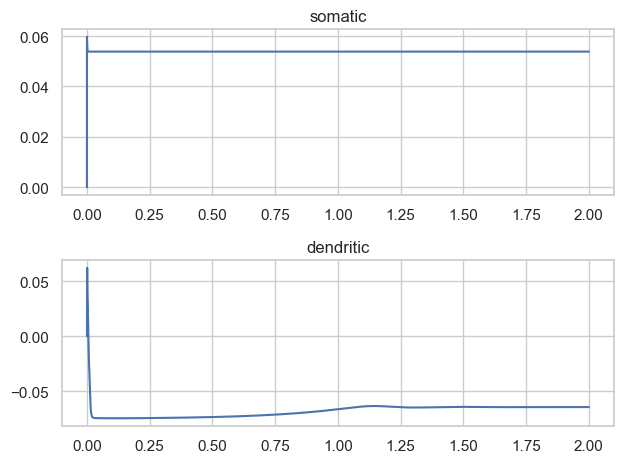

In [147]:
reset_params()
g_link = 0
vs, vd, spikes = pinsky_rinzel(t)
np.sum(spikes)

fig, ax = plt.subplots(2, 1)

ax[0].plot(t, vs)
ax[0].set_title('somatic')
ax[1].plot(t, vd)
ax[1].set_title('dendritic')

plt.tight_layout()

In [ ]:
reset_params()
g_link = 10e-9
vs, vd, spikes = pinsky_rinzel(t)
np.sum(spikes)

fig, ax = plt.subplots(2, 1)

ax[0].plot(t, vs)
ax[0].set_title('somatic')
ax[1].plot(t, vd)
ax[1].set_title('dendritic')

plt.tight_layout()

In [ ]:
reset_params()
g_link = 100e-9
vs, vd, spikes = pinsky_rinzel(t)
np.sum(spikes)

fig, ax = plt.subplots(2, 1)

ax[0].plot(t, vs)
ax[0].set_title('somatic')
ax[1].plot(t, vd)
ax[1].set_title('dendritic')

plt.tight_layout()